In [11]:
#Packages
import os
import pandas as pd
import numpy as np
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import matplotlib.pyplot as plt
import seaborn as sns
import shap

In [12]:
#Get Data
csv_dir = 'stuff_plus/SEC Trackman Data/'
all_files = [os.path.join(csv_dir, f) for f in os.listdir(csv_dir) if f.endswith('.csv')]

df_list = []

for file in all_files:
    df = pd.read_csv(file)
    df_list.append(df)

all_pitches = pd.concat(df_list, ignore_index=True)

print(all_pitches.shape)
print(all_pitches.columns)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'stuff_plus/SEC Trackman Data/'

In [ ]:
#Get all sliders
bbs = all_pitches[all_pitches['TaggedPitchType'].isin(['Slider'])]
print(bbs.shape)

In [ ]:
#Subset sliders into platoon splits
bbs_rr = bbs[(bbs['PitcherThrows'] == 'Right') & (bbs['BatterSide'] == 'Right')]
bbs_rl = bbs[(bbs['PitcherThrows'] == 'Right') & (bbs['BatterSide'] == 'Left')]
bbs_lr = bbs[(bbs['PitcherThrows'] == 'Left') & (bbs['BatterSide'] == 'Right')]
bbs_ll = bbs[(bbs['PitcherThrows'] == 'Left') & (bbs['BatterSide'] == 'Left')]

print(bbs_rr.shape)
print(bbs_rl.shape)
print(bbs_lr.shape)
print(bbs_ll.shape)

In [ ]:
#Whiffs
bbs_rr['whiff'] = np.where(bbs_rr['PitchCall']=='StrikeSwinging',1,0)
bbs_rl['whiff'] = np.where(bbs_rl['PitchCall']=='StrikeSwinging',1,0)
bbs_lr['whiff'] = np.where(bbs_lr['PitchCall']=='StrikeSwinging',1,0)
bbs_ll['whiff'] = np.where(bbs_ll['PitchCall']=='StrikeSwinging',1,0)

In [3]:
#Predictor Variables
preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']

Righty vs. Righty Split

In [4]:
bbs_rr_X = bbs_rr[preds]
bbs_rr_y = bbs_rr['whiff']

NameError: name 'bbs_rr' is not defined

In [9]:
#Train Model: RHP vs RHB
X_train, X_test, y_train, y_test = train_test_split(bbs_rr_X, bbs_rr_y, test_size=.33, random_state=25)

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 84.28%


ROC AUC: 0.5202


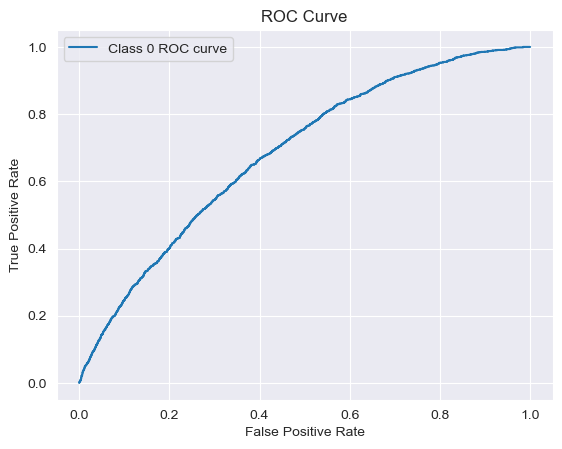

In [10]:
y_pred_prob = model.predict_proba(X_test)[:,1]
roc_auc = roc_auc_score(y_test, predictions, multi_class='ovr')

print(f'ROC AUC: {roc_auc:.4f}')

# Plotting ROC Curve for one class (e.g., class 0)
fpr, tpr, _ = roc_curve(y_test == 1, y_pred_prob)
plt.plot(fpr, tpr, label='Class 0 ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

In [11]:
# Get unique values
unique_values = bbs_rr['Pitcher'].unique()


#List of Pitchers that threw splitter, as well as amount
print(unique_values, len(unique_values))

# Create a dictionary to store subsets
subsets = {value: bbs_rr[bbs_rr['Pitcher'] == value] for value in unique_values}

['Dettmer, Nathan' 'Tidwell, Blade' 'Magers, Alex' ... 'Causey, A.J.'
 "O'Brien Cameron" 'Marlatt, Parker'] 1317


In [12]:
def rr_bbs_stuff(name):
    
    preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']
    
    all_preds = model.predict_proba(bbs_rr_X)[:,1]
    mean_pred = np.mean(all_preds)

    pitcher = subsets[name]
    pitcher_x = pitcher[preds]

    whiff_preds = model.predict_proba(pitcher_x)[:,1]

    stuff = whiff_preds/mean_pred
    
    return np.mean(stuff * 100)

    


In [13]:
#Stuff+ for selected pitchers Slider in RHP v RHB split
rr_bbs_stuff('Tilly, Cameron')

92.21162

Righty vs. Lefty Split

In [15]:
bbs_rl_X = bbs_rl[preds]
bbs_rl_y = bbs_rl['whiff']

In [16]:
#Train Model: RHP vs LHB
X_train, X_test, y_train, y_test = train_test_split(bbs_rl_X, bbs_rl_y, test_size=.33, random_state=25)

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 86.96%


In [17]:
# Get unique values
unique_values = bbs_rl['Pitcher'].unique()

#List of Pitchers that threw splitter, as well as amount
print(unique_values, len(unique_values))

# Create a dictionary to store subsets
subsets = {value: bbs_rl[bbs_rl['Pitcher'] == value] for value in unique_values}

['Dettmer, Nathan' 'Hunley, Sean' 'Werner, Trevor' ... "O'Brien Cameron"
 'Dossett, Cooper' 'Bybee, Ben'] 1014


In [18]:
def rl_bbs_stuff(name):
    
    preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']
    
    all_preds = model.predict_proba(bbs_rl_X)[:,1]
    mean_pred = np.mean(all_preds)

    pitcher = subsets[name]
    pitcher_x = pitcher[preds]

    whiff_preds = model.predict_proba(pitcher_x)[:,1]

    stuff = whiff_preds/mean_pred
    
    return np.mean(stuff * 100)


In [19]:
#Stuff+ for selected pitchers Slider in RHP v LHB split
rl_bbs_stuff('Tilly, Cameron')

107.983864

Lefty vs. Righty Split

In [20]:
bbs_lr_X = bbs_lr[preds]
bbs_lr_y = bbs_lr['whiff']

In [21]:
#Train Model: LHP vs RHB
X_train, X_test, y_train, y_test = train_test_split(bbs_lr_X, bbs_lr_y, test_size=.33, random_state=25)

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 83.85%


In [22]:
# Get unique values
unique_values = bbs_lr['Pitcher'].unique()

#List of Pitchers that threw splitter, as well as amount
print(unique_values, len(unique_values))

# Create a dictionary to store subsets
subsets = {value: bbs_lr[bbs_lr['Pitcher'] == value] for value in unique_values}


['Menefee, Joseph' 'Walsh, Redmond' 'Wall, Chris' 'Robertson, Trae'
 'LaCalameto, Kyle' 'Prayer, Cameron' 'Johnston, Will' 'Holguin, Al'
 'Gilreath, John' 'Rokose, Davis' 'Sullivan, Liam' 'Woods, Jaden'
 'Lohse, Ian' 'Sipe, Hunter' 'Atiya, Eli' 'Elliott, Hunter'
 'Dillard, Matt' 'Hanson, Sam' 'Seiler, Ben' 'Bauman, Tanner'
 'Hitt, Grayson' 'Goldstein, Charlie' 'Wagner, Luke' 'Keevan, LJ'
 'Armbrustmacher, Dane' 'Cooper, Riley' 'Ackenhausen, Nathan'
 'Davis, Tyler' 'Welch, Carter' 'Kimbrell, Jackson' 'Wansing, Troy'
 'Dayton, Cameron' 'Vail, Tommy' 'Clifton, Harrison' 'Davis, Alton'
 'Sibley, Joshua' 'Wheeler, Trey' 'Lopez, Will' 'Rivas, Xavier'
 'Grome, Chris' 'Hogan, Kian' 'Sdao, Shane' 'Crotchfelt, Zach'
 'Kraft, Ryan' 'Baker, Will' 'Morris, Zack' 'Bates, Ethan' 'Huff, Hollis'
 'Loftin, Bradley' 'Waterhouse, Quinn' 'Leger, Jake' 'Walter, Daniel'
 'Whittle, Parker' 'White, Aaron' 'Windham, Payton' 'Campbell, Tyler'
 'Corley, Brandt' 'Roberts, Tanner' 'Sewell, JC' 'Knight, Carson'
 'Gi

In [23]:
def lr_bbs_stuff(name):
    
    preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']
    
    all_preds = model.predict_proba(bbs_lr_X)[:,1]
    mean_pred = np.mean(all_preds)

    pitcher = subsets[name]
    pitcher_x = pitcher[preds]

    whiff_preds = model.predict_proba(pitcher_x)[:,1]

    stuff = whiff_preds/mean_pred
    
    return np.mean(stuff * 100)


In [24]:
#Stuff+ for selected pitchers Slider in LHP v RHB split
lr_bbs_stuff('Ackenhausen, Nathan')

163.7097

Lefty vs. Lefty Split

In [25]:
bbs_ll_X = bbs_ll[preds]
bbs_ll_y = bbs_ll['whiff']

In [26]:
#Train Model: LHP vs LHB
X_train, X_test, y_train, y_test = train_test_split(bbs_ll_X, bbs_ll_y, test_size=.33, random_state=25)

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 83.17%


In [27]:
# Get unique values
unique_values = bbs_ll['Pitcher'].unique()

#List of Pitchers that threw splitter, as well as amount
print(unique_values, len(unique_values))

# Create a dictionary to store subsets
subsets = {value: bbs_ll[bbs_ll['Pitcher'] == value] for value in unique_values}


['Menefee, Joseph' 'Walsh, Redmond' 'Wall, Chris' 'LaCalameto, Kyle'
 'Prayer, Cameron' 'Johnston, Will' 'Holguin, Al' 'Gilreath, John'
 'Rokose, Davis' 'Sullivan, Liam' 'Woods, Jaden' 'Lohse, Ian'
 'Sipe, Hunter' 'Elliott, Hunter' 'Atiya, Eli' 'Dillard, Matt'
 'Hanson, Sam' 'Seiler, Ben' 'Bauman, Tanner' 'Hitt, Grayson'
 'Furtado, Hunter' 'Goldstein, Charlie' 'Baker, Will' 'Keevan, LJ'
 'Armbrustmacher, Dane' 'Cooper, Riley' 'Ackenhausen, Nathan'
 'Davis, Tyler' 'Morgan, Trey' 'Welch, Carter' 'Wansing, Troy'
 'Dayton, Cameron' 'Lamkin, Justin' 'Bothwell, Ty' 'Sheehan, Tommy'
 'Vail, Tommy' 'Clifton, Harrison' 'Davis, Alton' 'Sibley, Joshua'
 'Wheeler, Trey' 'Phipps, Jackson' 'Lopez, Will' 'Light, Nathan'
 'Loftin, Bradley' 'Grome, Chris' 'Rivas, Xavier' 'Hogan, Kian'
 'Sdao, Shane' 'Crotchfelt, Zach' 'Kraft, Ryan' 'Reinke, Brian'
 'Wagner, Luke' 'Morris, Zack' 'Bates, Ethan' 'Grace, Ranard'
 'Herring, Griffin' 'Huff, Hollis' 'Waterhouse, Quinn' 'Leger, Jake'
 'Walter, Daniel' 'Parks, 

In [28]:
def ll_bbs_stuff(name):
    
    preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']
    
    all_preds = model.predict_proba(bbs_ll_X)[:,1]
    mean_pred = np.mean(all_preds)

    pitcher = subsets[name]
    pitcher_x = pitcher[preds]

    whiff_preds = model.predict_proba(pitcher_x)[:,1]

    stuff = whiff_preds/mean_pred
    
    return np.mean(stuff * 100)


In [30]:
#Stuff+ for selected pitchers Slider in LHP v LHB split
ll_bbs_stuff('Myers, Carson')

76.60381